# DOTA 2 Surrogate 

In [2]:
import pandas as pd
import numpy as np

import glob
import matplotlib.pyplot as plt
from joblib import dump, load

In [3]:
import json
with open('features_list.json', 'r') as fp:
    features_list = json.load(fp)
features_list

{'0': 'team',
 '1': 'level',
 '2': 'health',
 '3': 'max health',
 '4': 'health regen',
 '5': 'mana',
 '6': 'max mana',
 '7': 'mana regen',
 '8': 'base move speed',
 '9': 'current move speed',
 '10': 'base damage',
 '11': 'damage variance',
 '12': 'attack damage',
 '13': 'attack range buffer',
 '14': 'attack speed',
 '15': 'seconds per attack',
 '16': 'attack animation point',
 '17': 'last attack time',
 '18': 'attack target',
 '19': 'strength',
 '20': 'agility',
 '21': 'intellect',
 '22': 'gold',
 '23': 'net worth',
 '24': 'last hits',
 '25': 'denies',
 '26': 'location 1',
 '27': 'location 2',
 '28': 'facing',
 '29': 'vision range',
 '30': 'opp team',
 '31': 'opp level',
 '32': 'opp health',
 '33': 'opp max health',
 '34': 'opp health regen',
 '35': 'opp mana',
 '36': 'opp max mana',
 '37': 'opp mana regen',
 '38': 'opp base move speed',
 '39': 'opp curr move speed',
 '40': 'opp base damage',
 '41': 'opp damage variance',
 '42': 'opp attack damage',
 '43': 'opp attack range buffer',
 '

In [140]:
df1 = pd.read_csv("games_data/rd_cumulated_1.csv", index_col=0)
df2 = pd.read_csv("games_data/rd_cumulated_2.csv", index_col=0)
df = pd.concat([df1, df1], axis=0)
len(df)

26470

In [141]:
df = df.drop(columns='action')
# df.columns=features_list.values()
desc = df.describe()
desc

,0,1,2,3,4,5,6,7,8,9,...,300,301,302,303,304,305,306,307,308,309
count,26470.0,26470.000000,26470.000000,26470.000000,26470.000000,26470.000000,26470.000000,26470.000000,26470.0,26470.0,...,26470.0,26470.0,26470.0,26470.0,26470.0,26470.0,26470.0,26470.0,26470.0,26470.000000
mean,2.0,1.447903,602.550132,693.112202,8.264179,148.240214,357.389422,3.163826,305.0,0.0,...,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,-0.770155
std,0.0,0.727312,203.654946,41.172975,12.058049,113.759986,21.125055,5.658358,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.637869
min,2.0,1.000000,0.000000,600.000000,2.550000,1.000000,303.000000,1.400000,305.0,0.0,...,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,-1.000000
25%,2.0,1.000000,660.000000,660.000000,2.920000,56.596172,339.000000,1.400000,305.0,0.0,...,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,-1.000000
50%,2.0,1.000000,660.000000,680.000000,3.650000,98.000000,351.000000,1.450000,305.0,0.0,...,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,-1.000000
75%,2.0,2.000000,680.000000,720.000000,5.650000,254.999985,375.000000,1.560000,305.0,0.0,...,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,-1.000000
max,2.0,4.000000,840.000000,840.000000,78.550003,423.000000,423.000000,27.160000,305.0,0.0,...,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [119]:
# Generate dict {index : constant value}
for i, v in desc.loc['std'].items():
    if v == 0:
        print('%s : %.3f, \t#%s' %(i, desc.loc[:, i]['mean'], features_list[i]))

0 : 2.000, 	#team
8 : 305.000, 	#base move speed
9 : 0.000, 	#current move speed
11 : 9.000, 	#damage variance
13 : 250.000, 	#attack range buffer
16 : 0.500, 	#attack animation point
25 : 0.000, 	#denies
28 : 0.000, 	#facing
30 : 3.000, 	#opp team
38 : 305.000, 	#opp base move speed
39 : 0.000, 	#opp curr move speed
41 : 9.000, 	#opp damage variance
43 : 250.000, 	#opp attack range buffer
46 : 0.500, 	#opp attack animation point
54 : 0.000, 	#opp facing
57 : 2.000, 	#good tower team
59 : 1800.000, 	#good tower max health
61 : 250.000, 	#good tower attack range buffer
62 : 1.000, 	#good tower attack speed
63 : 3.000, 	#bad tower team
65 : 1800.000, 	#bad tower max health
67 : 250.000, 	#bad tower attack range buffer
68 : 1.000, 	#bad tower attack speed
69 : -69.000, 	#bounty 1 location 1
70 : -70.000, 	#bounty 1 location 2
71 : -71.000, 	#bounty 2 location 1
72 : -72.000, 	#bounty 2 location 2
73 : -73.000, 	#bounty 3 location 1
74 : -74.000, 	#bounty 3 location 2
75 : -75.000, 	#bount

In [121]:
constant_features ={0 : 2.000, 	#team
8 : 305.000, 	#base move speed
9 : 0.000, 	#current move speed
11 : 9.000, 	#damage variance
13 : 250.000, 	#attack range buffer
16 : 0.500, 	#attack animation point
25 : 0.000, 	#denies
28 : 0.000, 	#facing
30 : 3.000, 	#opp team
38 : 305.000, 	#opp base move speed
39 : 0.000, 	#opp curr move speed
41 : 9.000, 	#opp damage variance
43 : 250.000, 	#opp attack range buffer
46 : 0.500, 	#opp attack animation point
54 : 0.000, 	#opp facing
57 : 2.000, 	#good tower team
59 : 1800.000, 	#good tower max health
61 : 250.000, 	#good tower attack range buffer
62 : 1.000, 	#good tower attack speed
63 : 3.000, 	#bad tower team
65 : 1800.000, 	#bad tower max health
67 : 250.000, 	#bad tower attack range buffer
68 : 1.000, 	#bad tower attack speed
69 : -69.000, 	#bounty 1 location 1
70 : -70.000, 	#bounty 1 location 2
71 : -71.000, 	#bounty 2 location 1
72 : -72.000, 	#bounty 2 location 2
73 : -73.000, 	#bounty 3 location 1
74 : -74.000, 	#bounty 3 location 2
75 : -75.000, 	#bounty 4 location 1
76 : -76.000, 	#bounty 4 location 2
77 : -77.000, 	#power 1 location 1
78 : -78.000, 	#power 1 location 2
79 : -79.000, 	#power 2 location 1
80 : -80.000, 	#power 2 location 2
226 : 90.000, 	#ability 1 mana cost
227 : 0.000, 	#ability 1 ability damage
228 : 200.000, 	#ability 1 cast range
230 : 0.000, 	#ability 1 target type
231 : 0.000, 	#ability 1 behavior
233 : 90.000, 	#ability 2 mana cost
234 : 0.000, 	#ability 2 ability damage
235 : 450.000, 	#ability 2 cast range
237 : 0.000, 	#ability 2 target type
238 : 0.000, 	#ability 2 behavior
240 : 90.000, 	#ability 3 mana cost
241 : 0.000, 	#ability 3 ability damage
242 : 700.000, 	#ability 3 cast range
244 : 0.000, 	#ability 3 target type
245 : 0.000, 	#ability 3 behavior
247 : 0.000, 	#ability 4 mana cost
248 : 0.000, 	#ability 4 ability damage
249 : 0.000, 	#ability 4 cast range
250 : 0.000, 	#ability 4 cooldown time remaining
251 : 0.000, 	#ability 4 target type
252 : 0.000, 	#ability 4 behavior
253 : 0.000, 	#ability 5 level
254 : 0.000, 	#ability 5 mana cost
255 : 0.000, 	#ability 5 ability damage
256 : 0.000, 	#ability 5 cast range
257 : 0.000, 	#ability 5 cooldown time remaining
258 : 0.000, 	#ability 5 target type
259 : 0.000, 	#ability 5 behavior
260 : 0.000, 	#ability 6 level
261 : 150.000, 	#ability 6 mana cost
262 : 0.000, 	#ability 6 ability damage
263 : 0.000, 	#ability 6 cast range
264 : 0.000, 	#ability 6 cooldown time remaining
265 : 0.000, 	#ability 6 target type
266 : 0.000, 	#ability 6 behavior
268 : 90.000, 	#opp ability 1 mana cost
269 : 0.000, 	#opp ability 1 ability damage
272 : 0.000, 	#opp ability 1 target type
273 : 0.000, 	#opp ability 1 behavior
275 : 90.000, 	#opp ability 2 mana cost
276 : 0.000, 	#opp ability 2 ability damage
279 : 0.000, 	#opp ability 2 target type
280 : 0.000, 	#opp ability 2 behavior
282 : 90.000, 	#opp ability 3 mana cost
283 : 0.000, 	#opp ability 3 ability damage
286 : 0.000, 	#opp ability 3 target type
287 : 0.000, 	#opp ability 3 behavior
289 : 0.000, 	#opp ability 4 mana cost
290 : 0.000, 	#opp ability 4 ability damage
291 : 0.000, 	#opp ability 4 cast range
292 : 0.000, 	#opp ability 4 cooldown time remaining
293 : 0.000, 	#opp ability 4 target type
294 : 0.000, 	#opp ability 4 behavior
295 : 0.000, 	#opp ability 5 level
296 : 0.000, 	#opp ability 5 mana cost
297 : 0.000, 	#opp ability 5 ability damage
298 : 0.000, 	#opp ability 5 cast range
299 : 0.000, 	#opp ability 5 cooldown time remaining
300 : 0.000, 	#opp ability 5 target type
301 : 0.000, 	#opp ability 5 behavior
302 : 0.000, 	#opp ability 6 level
303 : 150.000, 	#opp ability 6 mana cost
304 : 0.000, 	#opp ability 6 ability damage
305 : 0.000, 	#opp ability 6 cast range
306 : 0.000, 	#opp ability 6 cooldown time remaining
307 : 0.000, 	#opp ability 6 target type
308 : 0.000 	#opp ability 6 behavior
                   }

-- level --
count    26470.000000
mean         1.447903
std          0.727312
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: level, dtype: float64


Text(0.5, 0, 'Record #')

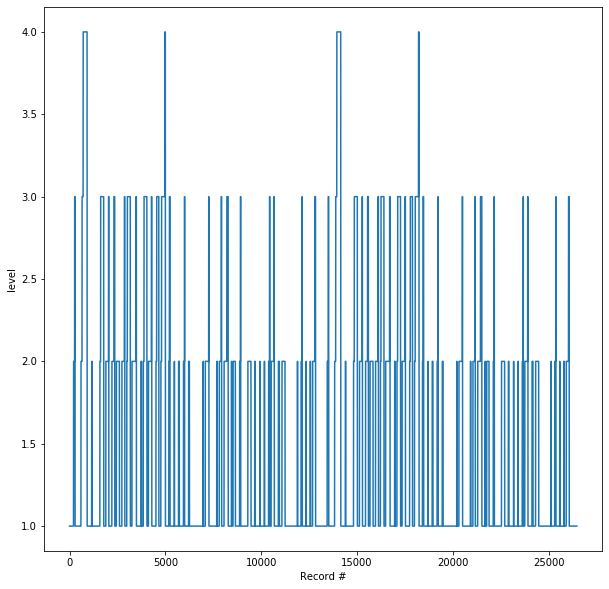

In [9]:
feature = 'level'

print("-- %s --" %feature)
print(desc[feature])
# df = df.loc[:500]
plt.figure(figsize=(10, 10))
plt.plot(range(len(df)), df[feature])
plt.ylabel(feature)
plt.xlabel("Record #")

In [129]:
s = [i for i in range(310)]
df = pd.DataFrame([[i for i in range(310)] for j in range(200)])

print(s)
df.head()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

,0,1,2,3,4,5,6,7,8,9,...,300,301,302,303,304,305,306,307,308,309
0,0,1,2,3,4,5,6,7,8,9,...,300,301,302,303,304,305,306,307,308,309
1,0,1,2,3,4,5,6,7,8,9,...,300,301,302,303,304,305,306,307,308,309
2,0,1,2,3,4,5,6,7,8,9,...,300,301,302,303,304,305,306,307,308,309
3,0,1,2,3,4,5,6,7,8,9,...,300,301,302,303,304,305,306,307,308,309
4,0,1,2,3,4,5,6,7,8,9,...,300,301,302,303,304,305,306,307,308,309


In [169]:
def remove_constants(state):
    if type(state)==pd.DataFrame:
        return state.drop(columns=[str(i) for i in constant_features.keys()])
    else: # List / array
        return np.delete(state, list(constant_features.keys()))

def add_constants(state):
    if type(state)==pd.DataFrame:
        for k, v in constant_features.items():
            state[k]=v
        state = state[[i for i in range(310)]]
        return state
    else: # List / array
        for k, v in constant_features.items():
            state = np.insert(state, k, v)
        return state

In [170]:
light_df = remove_constants(df)
light_df.head()

,1,2,3,4,5,6,7,10,12,14,...,270,271,274,277,278,281,284,285,288,309
0,1,600,600,32.250000,303.0,303,19.430000,39,40,1.21,...,0,0.0,0,0,0.0,0,0,0.0,0,1
1,1,620,620,33.349998,315.0,315,20.199999,40,37,1.22,...,0,0.0,0,0,0.0,0,0,0.0,1,1
2,1,620,620,33.349998,315.0,315,20.199999,43,44,1.25,...,0,0.0,0,0,0.0,0,0,0.0,1,1
3,1,660,660,35.549999,339.0,339,21.740000,45,45,1.27,...,0,0.0,0,0,0.0,0,0,0.0,1,1
4,1,660,660,35.549999,339.0,339,21.740000,45,48,1.27,...,0,0.0,0,0,0.0,0,0,0.0,1,1


In [139]:
add_constants(light_df).head()

,0,1,2,3,4,5,6,7,8,9,...,300,301,302,303,304,305,306,307,308,309
0,2.0,1,2,3,4,5,6,7,305.0,0.0,...,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,309
1,2.0,1,2,3,4,5,6,7,305.0,0.0,...,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,309
2,2.0,1,2,3,4,5,6,7,305.0,0.0,...,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,309
3,2.0,1,2,3,4,5,6,7,305.0,0.0,...,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,309
4,2.0,1,2,3,4,5,6,7,305.0,0.0,...,0.0,0.0,0.0,150.0,0.0,0.0,0.0,0.0,0.0,309


In [142]:
light_s = remove_constants(s)
light_s

array([  1,   2,   3,   4,   5,   6,   7,  10,  12,  14,  15,  17,  18,
        19,  20,  21,  22,  23,  24,  26,  27,  29,  31,  32,  33,  34,
        35,  36,  37,  40,  42,  44,  45,  47,  48,  49,  50,  51,  52,
        53,  55,  56,  58,  60,  64,  66,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 21

In [137]:
add_constants(light_s)

array([   2,    1,    2,    3,    4,    5,    6,    7,  305,    0,   10,
          9,   12,  250,   14,   15,    0,   17,   18,   19,   20,   21,
         22,   23,   24,    0,   26,   27,    0,   29,    3,   31,   32,
         33,   34,   35,   36,   37,  305,    0,   40,    9,   42,  250,
         44,   45,    0,   47,   48,   49,   50,   51,   52,   53,    0,
         55,   56,    2,   58, 1800,   60,  250,    1,    3,   64, 1800,
         66,  250,    1,  -69,  -70,  -71,  -72,  -73,  -74,  -75,  -76,
        -77,  -78,  -79,  -80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1